In [1]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

import numpy as np
import scipy as sp

import pymc3 as pm
import theano.tensor as tt


import seaborn as sns
from google.colab import drive

from matplotlib import cm
from pymc3.gp.util import plot_gp_dist
drive.mount('/content/drive')







Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install pymc3 --upgrade  #run this every first run

Primary resources for making this: 
https://docs.pymc.io/notebooks/GP-Marginal.html
https://github.com/fonnesbeck/gp_regression

Look into: 
https://docs.pymc.io/notebooks/posterior_predictive.html


In [3]:
##### OPTIONS #####

map = 1       # 1 - use find map, 0 - sample 
samples = 500
tune = 1000

errorbars = 0   # plot error bars on surface plot 
smp_rt = 2      # every nth point of true data
num_gen = 100   # given n will produce n x n points of predictions




data = np.genfromtxt('/content/drive/My Drive/data/gyro_fake_data_v1.csv', delimiter=',', skip_header=1)


In [4]:
class Sqr_root2d(pm.gp.mean.Mean):
    '''Custom mean func of sqr root'''
    def __init__(self, coeffs=0, intercept=0):
        pm.gp.mean.Mean.__init__(self)
        self.b = intercept
        self.A = coeffs

    def __call__(self, X):
        #return tt.squeeze(tt.dot(np.sqrt(X[:,0] + X[:,1] )**0.5, self.A) + self.b)
        f = tt.dot(np.sqrt(X), self.A) + self.b
       # return tt.alloc(f, X.shape[0])
        #return tt.alloc(tt.add(tt.dot(tt.sqrt(X), self.A), self.B), X.shape[0])
        return tt.squeeze(tt.dot(X, self.A) + self.b)

In [5]:

X1 = data[:, 1][0::smp_rt]  # rotation
X2 = data[:, 2][0::smp_rt]  # B-V 
y = data[:, 3][0::smp_rt]   # Age

Xs = np.array([X1, X2]).T

print(Xs.shape)



#nd = 20

#xu1, xu2 = np.meshgrid(np.linspace(np.amin(X1), np.amax(X1), nd), np.linspace(np.amin(X2), np.amax(X2), nd))
#Xu = np.concatenate([xu1.reshape(nd*nd, 1), xu2.reshape(nd*nd, 1)], 1).T
# array of inducing points - not too sure what this means but I think its used to reduce the number of input data points and thus computatioanl stress 
'''

with pm.Model() as model:
    

    # Look into making it into 1 cov function and array of ls 
    
  #  l1 = pm.Normal('l1', mu = 1, sigma=0.5)
 #   l2 = pm.Normal('l2', mu=25, sigma=5)

    l1 = 40
    l2 = 80


    sigmaf1 = pm.Normal('sigmaf1', mu=30, sigma= 3)
    sigmaf2 = pm.Normal('sigmaf2', mu=20, sigma = 3)


    sigman = pm.HalfCauchy('sigman', beta=3)
    #sigman = pm.Constant('sigman', c=0)
    
    #mean = Sqr_root2d([y/Xs[:,0], y/Xs[:,1]]) # This is where I have the best success
    #mean = pm.gp.mean.Constant(c=y.mean())
    

    K1 = pm.gp.cov.ExpQuad(2, l1) * sigmaf1**2


    K2 = pm.gp.cov.ExpQuad(2, l2) * sigmaf2**2

    


    # New kernels to try
    # cov = tau * pm.gp.cov.RatQuad(1, l, alpha)                   - rational quadratic


    mean = pm.gp.mean.Zero()
    
    K = K1 * K2
    #K = K1 + K2


    gp = pm.gp.Marginal(cov_func=K, mean_func=mean)
    obs = gp.marginal_likelihood("obs", X=Xs, y=y, noise=sigman)

    if map:
        mp = pm.find_MAP()
    
'''
with pm.Model() as model:
    l1 = pm.Normal('l1', mu=11, sigma=1)
    l2 = pm.Normal('l2', mu=0.5, sigma=0.2)
    #l = pm.HalfCauchy("l", beta=3, shape=(2,))
    l = [l1, l2]
    #sf2 = pm.HalfCauchy("sf2", beta=8)
    sf2 = pm.Normal("sf2", mu=150, sigma=50)
    sn2 = pm.HalfCauchy("sn2", beta=3)

    K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    
    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=Xs, y=y, noise=sn2)
    if map:
        mp = pm.find_MAP()



(500, 2)


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [6]:
if not map:
  with model:
    mp = pm.sample(samples, tune=tune, cores=1)



In [7]:
if not map:
  with model: 
    print(pm.summary(mp).round(2))
else:
  print(mp)

{'l1': array(11.58281811), 'l2': array(0.5095759), 'sf2': array(110.34832441), 'sn2_log__': array(0.06098277), 'sn2': array(1.0628806)}


In [8]:


Xnew1 = np.linspace(np.amin(X1), np.amax(X1), num_gen)
Xnew2 = np.linspace(np.amin(X2), np.amax(X2), num_gen)

Xnew1, Xnew2 = np.meshgrid(Xnew1, Xnew2)

Xnew = np.stack((Xnew1, Xnew2)).T
Xnew_pred = Xnew.reshape(num_gen**2, 2)

#num_samples = 200
#with model:
 # f_pred = gp.conditional('f_pred1', Xnew_pred, pred_noise=False) # predict function
 # pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=num_samples) # predicts 1000 data points?

 ## fast_sample_posterior_predictive is a faster alternative

In [9]:
mu, var = gp.predict(Xnew_pred, point=mp, diag=True, pred_noise=True)
sd = np.sqrt(var)

mu = mu.reshape(num_gen, num_gen).T

sd = sd.reshape(num_gen, num_gen).T  #do I need to .T here? 
  ## maybe not but it doesnt work if I dont B^)


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


No handles with labels found to put in legend.


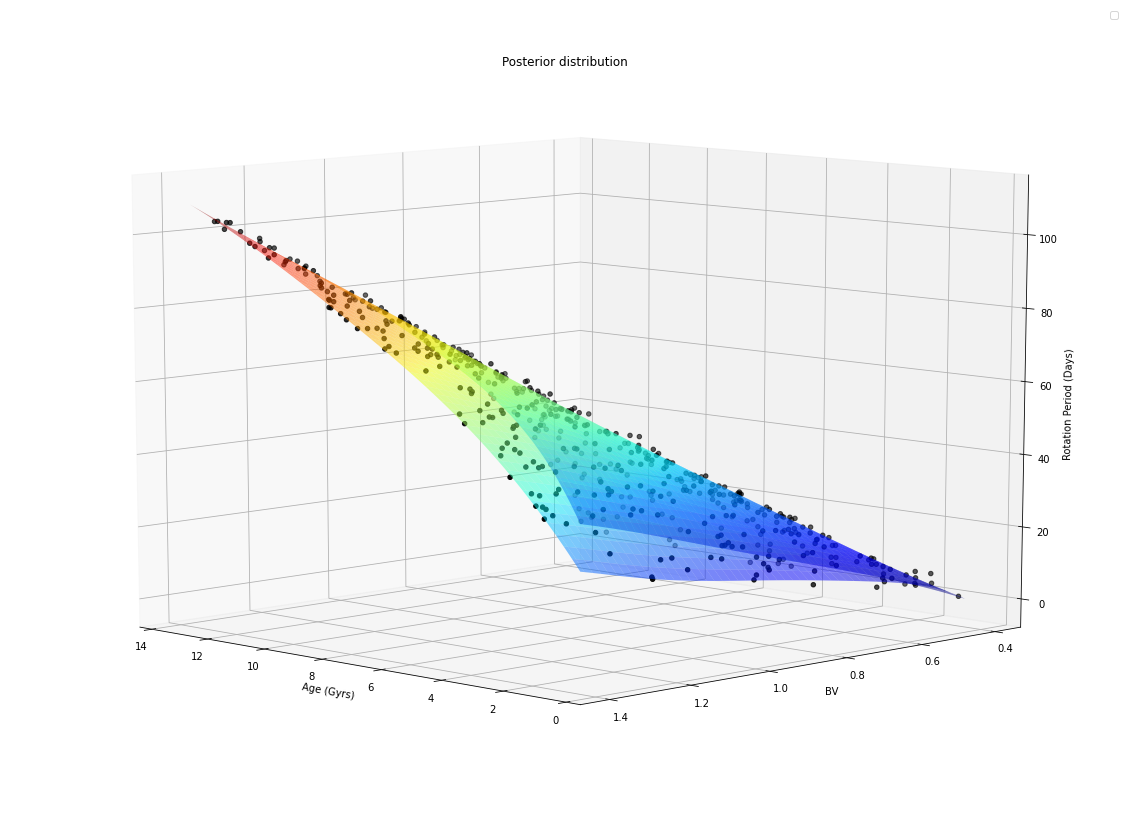

In [10]:

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(111, projection='3d')



if errorbars:
  for j in range(len(Xnew1)):
    for i in range(len(Xnew1)):
      plt.plot([Xnew1[i,j], Xnew1[i,j]], [Xnew2[i,j], Xnew2[i,j]], [mu[i,j] +sd[i,j], mu[i,j]-sd[i,j]], marker="_" )


ax1.plot_surface(Xnew1, Xnew2, mu, alpha=0.5, cmap=cm.jet, linewidth=0.1)

ax1.set_xlabel("Age (Gyrs)")
ax1.set_ylabel("BV")
ax1.set_zlabel('Rotation Period (Days)')


ax1.scatter(X1, X2, y, color='k')



# axis labels and title

plt.title("Posterior distribution")
plt.legend()
ax1.view_init(10, 135)
plt.show()





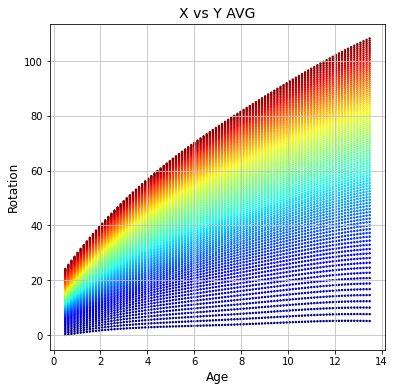

In [17]:
import matplotlib.pyplot as plt
from matplotlib  import cm
import numpy as np

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("X vs Y AVG",fontsize=14)
ax.set_xlabel("Age",fontsize=12)
ax.set_ylabel("Rotation",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')



# scatter with colormap mapping to z value
ax.scatter(Xnew1 ,mu, s=2, c=Xnew2, marker = 'o', cmap = cm.jet );

plt.show()

-2.388802303855823


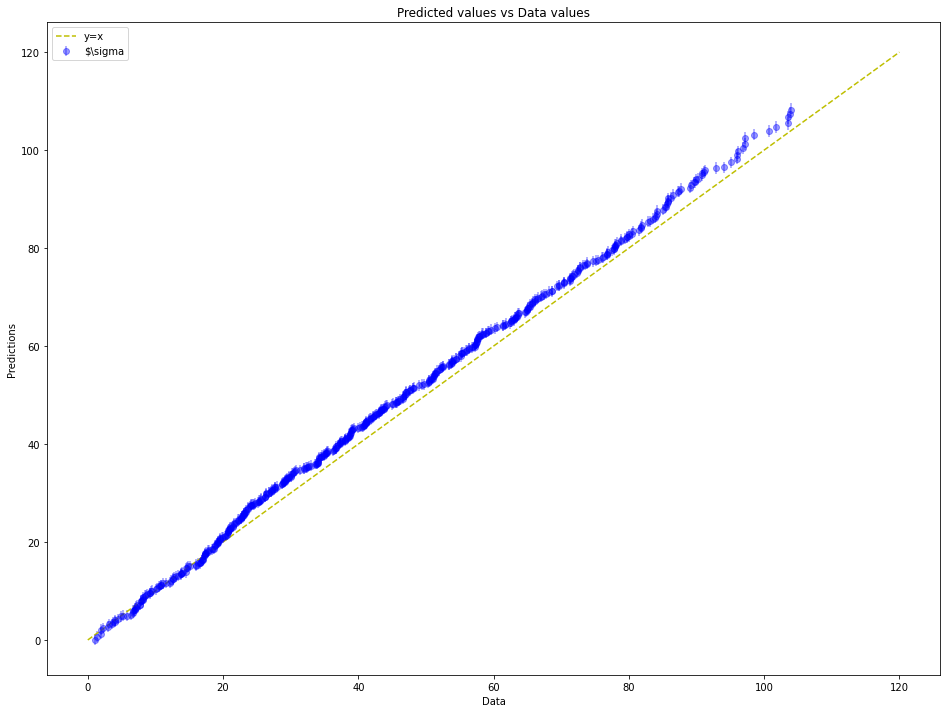

In [12]:
numElems = len(y)
idx = np.round(np.linspace(0, len(mu.reshape(num_gen**2)) - 1, numElems)).astype(int)
# Picks equal spaced elements from (longer) prediction array so that its shape of data

mu_test = (mu.reshape(num_gen**2)[idx])
sd_test = (sd.reshape(num_gen**2)[idx]) 

vals = np.sort([mu_test, sd_test], axis=1)
# sorts them together :) 

fig = plt.figure(figsize=(16,12))

plt.plot([0,120],[0,120], linestyle='--', label='y=x', color='y')
plt.errorbar(np.sort(y), vals[0,:], yerr=vals[1,:], fmt='o', label=r'$\sigma', color='b', alpha=0.4)


plt.xlabel("Data")
plt.ylabel("Predictions")
plt.title("Predicted values vs Data values")
plt.legend()
print(np.mean(np.sort(y)- vals[0,:]))

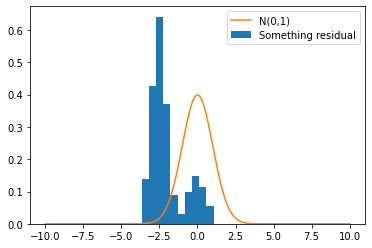

In [13]:
Z = (np.sort(y) - vals[0,:])/(vals[1,:])**2


x = np.linspace(-10,10, 1000)
f = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2)

plt.hist(Z, density=True, label='Something residual')
 
plt.plot(x,f, label='N(0,1)')
plt.legend()
## If I add 0.5 to all values of sigma, this fits really well. Seem to be under-predicting sigma


In [14]:


print('Badness 1: ', np.mean(np.sort(y)- vals[0,:]))

print('Badness 2: ',  np.abs(Z).mean())

Badness 1:  -2.388802303855823
Badness 2:  2.0851528907908436


In [15]:
print(map)

1


In [16]:
print('before: 4.78833254872231')

print('''with,     l1 = pm.Normal('l1', mu = 3.5, sigma=0.5)
    l2 = pm.Normal('l2', mu=25, sigma=5)


    sigmaf1 = pm.Normal('sigmaf1', mu=48, sigma= 5)
    sigmaf2 = pm.Normal('sigmaf2', mu=36, sigma = 5)''')


print(mu)
print(sd)

before: 4.78833254872231
with,     l1 = pm.Normal('l1', mu = 3.5, sigma=0.5)
    l2 = pm.Normal('l2', mu=25, sigma=5)


    sigmaf1 = pm.Normal('sigmaf1', mu=48, sigma= 5)
    sigmaf2 = pm.Normal('sigmaf2', mu=36, sigma = 5)
[[1.72180588e-02 2.03671440e-01 3.81957313e-01 ... 5.15451120e+00
  5.12927790e+00 5.09857542e+00]
 [6.68079801e-01 8.85376501e-01 1.09418586e+00 ... 7.63444650e+00
  7.61832042e+00 7.59648643e+00]
 [1.28134452e+00 1.52882061e+00 1.76748189e+00 ... 1.00258745e+01
  1.00189146e+01 1.00060243e+01]
 ...
 [2.35458112e+01 2.50607605e+01 2.65501665e+01 ... 1.05701829e+02
  1.06202872e+02 1.06693241e+02]
 [2.38238000e+01 2.53369972e+01 2.68249032e+01 ... 1.06450817e+02
  1.06959123e+02 1.07456759e+02]
 [2.40965541e+01 2.56077167e+01 2.70938500e+01 ... 1.07197909e+02
  1.07713656e+02 1.08218737e+02]]
[[1.31832767 1.29325923 1.27167352 ... 1.16638341 1.18067676 1.19804981]
 [1.27136407 1.24835765 1.22876485 ... 1.14576753 1.15895935 1.17511414]
 [1.23480356 1.21366131 1.195